## Artigo 1

A proposta desse arquivo é desenvolver uma técnica que permite otmizar a seleção de vértices e arestas de suporte.

A ideia é usar vários classificadores de baixa capacidade e, consequentemente, fáceis de treinar para selecionar uma porção da amostra que será canditada a compor o novo classificador.

Será baseado em classificadores de grafo de gabriel.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gg
import time
import helper

## Geração de diferente conjutos de dados sintéticos

In [2]:
def generate_separated_sines(n=200, x_min=0, x_max=4*np.pi, shift=1.5, noise_sigma=0.1, seed=0):
    rng = np.random.RandomState(seed)
    x = np.sort(rng.uniform(x_min, x_max, size=n))
    y_upper = np.sin(x) + shift + rng.normal(0, noise_sigma, size=n)
    y_lower = np.sin(x) - shift + rng.normal(0, noise_sigma, size=n)
    X_upper = np.column_stack([x, y_upper])
    X_lower = np.column_stack([x, y_lower])
    X = np.vstack([X_upper, X_lower])
    labels = np.hstack([-1*np.ones(n), np.ones(n)])
    return X, labels

def gaussian_blobs(n=100):
    X0 = np.random.randn(n, 2) + np.array([-2.3, -2.3])
    X1 = np.random.randn(n, 2) + np.array([ 2.3,  2.3])
    X = np.vstack([X0, X1])
    y = np.hstack([-1*np.ones(n), np.ones(n)])
    return X, y

def parallel_stripes(n=100):
    X0 = np.random.rand(n, 2) * 2 + np.array([0, 0])
    X1 = np.random.rand(n, 2) * 2 + np.array([3, 0])
    X = np.vstack([X0, X1])
    y = np.hstack([-1*np.ones(n), np.ones(n)])
    return X, y

def diagonal_split(n=200):
    X = np.random.uniform(-3, 3, size=(n, 2))
    y = np.where(X[:,0] + X[:,1] > 0, 1, -1)
    return X, y

def squares(n=100):
    X0 = np.random.rand(n, 2) + np.array([0, 0])
    X1 = np.random.rand(n, 2) + np.array([2, 2])
    X = np.vstack([X0, X1])
    y = np.hstack([-1*np.ones(n), np.ones(n)])
    return X, y

In [3]:
np.random.seed(2025)
# Escolha do dataset
x, y = parallel_stripes(n=200)

helper.print_hi('PyCharm')

Hi, PyCharm


## Perceptron

In [4]:
def train_perceptron(X, y, lr=0.01, epochs=100, bias=True, verbose=True):
    if bias:
        Xw = np.hstack([np.ones((X.shape[0],1)), X])
    else:
        Xw = X
    w = np.random.uniform(-2, 2, Xw.shape[1])
    for ep in range(epochs):
        errors = 0
        for i in np.random.permutation(Xw.shape[0]):
            a = np.dot(w, Xw[i])
            if y[i]*a <= 0:
                w += lr * y[i] * Xw[i]
                errors += 1
        if verbose:
            print(f"Epoch {ep+1}/{epochs} Error={errors/Xw.shape[0]:.4f}")
    return w

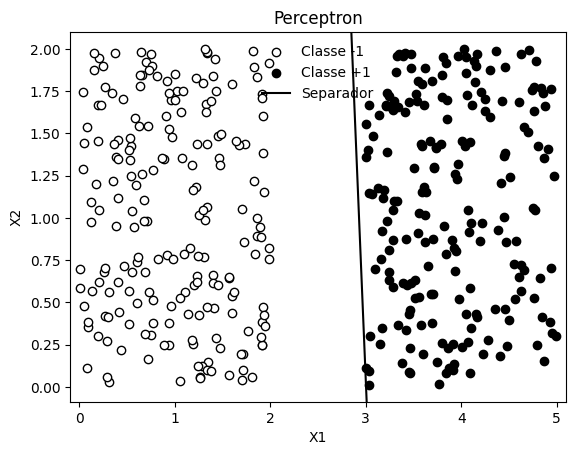

In [5]:
w_demo = train_perceptron(x, y, lr=0.1, epochs=2, bias=True, verbose=False)
plt.scatter(x[y==-1,0], x[y==-1,1], facecolors='1', edgecolors='0', label='Classe -1')
plt.scatter(x[y==1,0],  x[y==1,1],  facecolors='0', edgecolors='0', label='Classe +1')
plt.xlabel('X1'); plt.ylabel('X2')
plt.xlim(x[:,0].min()-.1, x[:,0].max()+.1)
plt.ylim(x[:,1].min()-.1, x[:,1].max()+.1)
xv = np.linspace(*plt.xlim(), 50)
yv = -(w_demo[0] + w_demo[1]*xv)/w_demo[2]
plt.plot(xv, yv, 'k', label='Separador')
plt.title('Perceptron')
plt.legend(frameon=False)
plt.show()

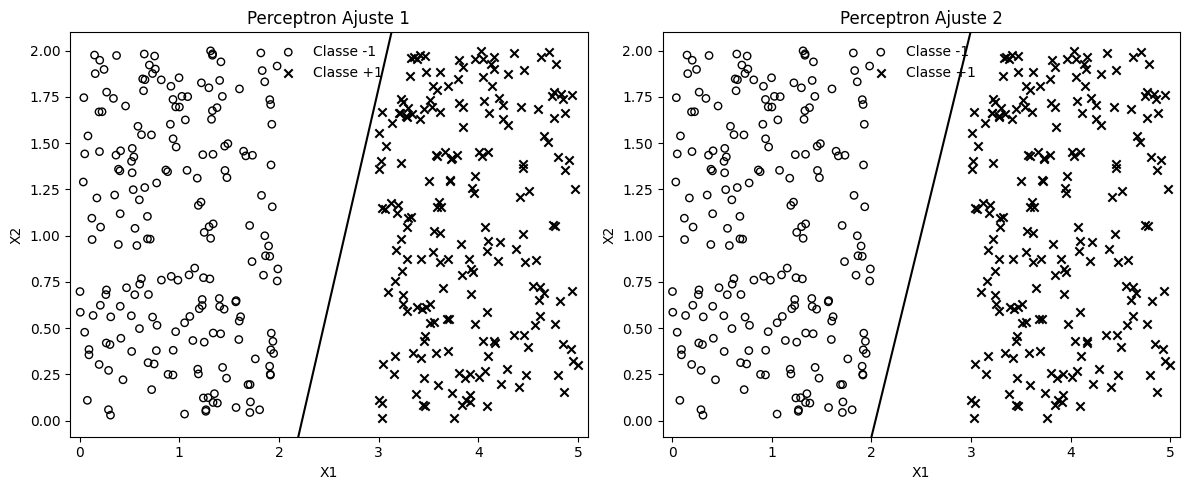

In [6]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
w1 = train_perceptron(x,y,lr=0.1,epochs=2,bias=True,verbose=False)
w2 = train_perceptron(x,y,lr=0.1,epochs=2,bias=True,verbose=False)
for ax, w, title in zip(axs, [w1,w2], ['Perceptron Ajuste 1','Perceptron Ajuste 2']):
    ax.scatter(x[y==-1,0], x[y==-1,1], facecolors='none', edgecolors='k', s=28, label='Classe -1')
    ax.scatter(x[y==1,0],  x[y==1,1],  c='k', marker='x', s=36, label='Classe +1')
    ax.set_xlim(x[:,0].min()-.1, x[:,0].max()+.1)
    ax.set_ylim(x[:,1].min()-.1, x[:,1].max()+.1)
    xv = np.linspace(*ax.get_xlim(), 50)
    yv = -(w[0] + w[1]*xv)/w[2]
    ax.plot(xv, yv, 'k')
    ax.set_title(title)
    ax.set_xlabel('X1'); ax.set_ylabel('X2')
    ax.legend(frameon=False)
plt.tight_layout(); plt.show()

## Seleção de índices candidatos (margem)

In [7]:
def select_closest_to_margin(X, y, w, k=0.1, bias=True):
    Xw = np.hstack([np.ones((X.shape[0],1)), X]) if bias else X
    idx0 = np.where(y==-1)[0]; idx1 = np.where(y==1)[0]
    d0 = np.abs(Xw[idx0] @ w)/np.linalg.norm(w[1:] if bias else w)
    d1 = np.abs(Xw[idx1] @ w)/np.linalg.norm(w[1:] if bias else w)
    n0 = max(1, int(len(idx0)*k)); n1 = max(1, int(len(idx1)*k))
    sel0 = idx0[np.argsort(d0)[:n0]]
    sel1 = idx1[np.argsort(d1)[:n1]]
    return np.hstack([sel0, sel1])

def select_by_perceptron_rounds(X, y, k=0.1, *, rounds=5, epochs_per_round=2, lr=0.1, bias=True, verbose=True):
    selected = set()
    for r in range(1, rounds+1):
        w = train_perceptron(X,y,lr=lr,epochs=epochs_per_round,bias=bias,verbose=False)
        new = select_closest_to_margin(X,y,w,k=k,bias=bias)
        before = len(selected)
        for i in new: selected.add(int(i))
        if verbose:
            print(f'Rodada {r}: +{len(selected)-before} (total {len(selected)})')
    return np.array(sorted(selected), dtype=int)

## Construção dos Grafos (completo e reduzido)

In [8]:
t0 = time.time()
G1 = gg.GabrielGraph(device='cpu')
G1.build(x, y)
t1 = time.time()
print(f'Tempo construção G1: {t1-t0:.4f}s')

sel_ind = select_by_perceptron_rounds(x,y,k=0.05,rounds=15,epochs_per_round=2,lr=0.1,bias=True,verbose=False)
x_sel = x[sel_ind]; y_sel = y[sel_ind]
print(f'Selected {len(x_sel)} / {len(x)}')
G2 = gg.GabrielGraph(device='cpu')
G2.build(x_sel, y_sel)
t2 = time.time()
print(f'Tempo construção G2: {t2-t1:.4f}s')

edges = list(G1.edges()); num_edges = len(edges)
edges2 = list(G2.edges()); num_edges2 = len(edges2)

Tempo construção G1: 0.1270s
Selected 47 / 400
Tempo construção G2: 0.0146s


In [9]:
common_indices = np.array(sel_ind, dtype=int)
print(f'Total completo: {x.shape[0]} | reduzido: {len(common_indices)}')
support_vertices_full = set()
for i,j in G1.support_edges():
    support_vertices_full.add(int(i)); support_vertices_full.add(int(j))
support_vertices_sub = set()
for i,j in G2.support_edges():
    support_vertices_sub.add(int(sel_ind[i])); support_vertices_sub.add(int(sel_ind[j]))
inter_support = support_vertices_full & support_vertices_sub
print(f'Suporte full: {len(support_vertices_full)} | suporte sub: {len(support_vertices_sub)} | interseção: {len(inter_support)}')
if support_vertices_full:
    print(f'Cobertura: {100*len(inter_support)/len(support_vertices_full):.2f}%')

Total completo: 400 | reduzido: 47
Suporte full: 14 | suporte sub: 14 | interseção: 14
Cobertura: 100.00%


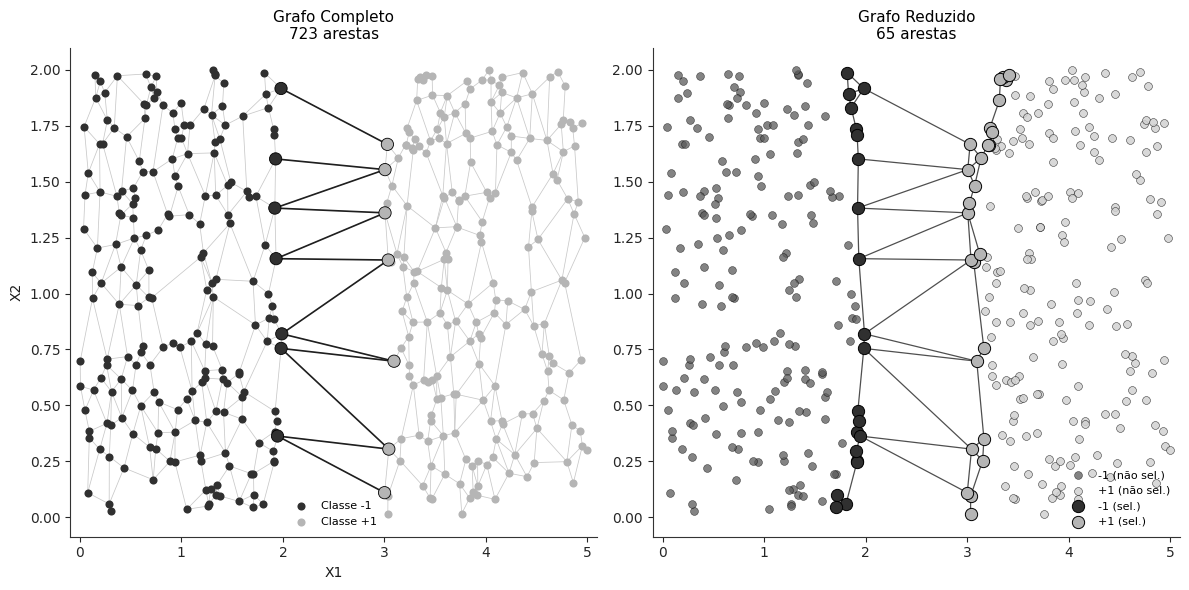

In [10]:
import matplotlib as mpl
mpl.rcParams.update({'axes.edgecolor':'0.2','axes.labelcolor':'0.1','xtick.color':'0.15','ytick.color':'0.15'})
color_neg='#303030'; color_pos='#b5b5b5'
non_mask = np.ones(len(x), dtype=bool); non_mask[sel_ind]=False
x_non = x[non_mask]; y_non = y[non_mask]
fig, axs = plt.subplots(1,2, figsize=(12,6))
# Painel 1
ax = axs[0]
ax.set_title(f'Grafo Completo\n{num_edges} arestas', fontsize=11)
for (i,j) in edges:
    ax.plot([x[i,0],x[j,0]],[x[i,1],x[j,1]],color='#c8c8c8',lw=0.55,zorder=0)
sup_edges_full = list(G1.support_edges())
sup_vertices_full = set()
for i,j in sup_edges_full:
    ax.plot([x[i,0],x[j,0]],[x[i,1],x[j,1]],color='#1f1f1f',lw=1.2,zorder=1)
    sup_vertices_full.add(int(i)); sup_vertices_full.add(int(j))
ax.scatter(x[y==-1,0],x[y==-1,1],s=34,c=color_neg,edgecolors='k',linewidths=0,label='Classe -1',zorder=2)
ax.scatter(x[y==1,0], x[y==1,1], s=34,c=color_pos,edgecolors='k',linewidths=0,label='Classe +1',zorder=2)
sup_vertices_full = np.array(list(sup_vertices_full))
if len(sup_vertices_full):
    ax.scatter(x[sup_vertices_full,0],x[sup_vertices_full,1],
               s=78,c=[color_neg if yy==-1 else color_pos for yy in y[sup_vertices_full]],
               edgecolors='k',linewidths=0.6,zorder=3)
ax.set_xlabel('X1'); ax.set_ylabel('X2')
# Painel 2
ax = axs[1]
ax.set_title(f'Grafo Reduzido\n{num_edges2} arestas', fontsize=11)
ax.scatter(x_non[y_non==-1,0],x_non[y_non==-1,1],s=32,c='#5a5a5a',edgecolors='k',linewidths=0.35,alpha=0.75,label='-1 (não sel.)',zorder=0)
ax.scatter(x_non[y_non==1,0], x_non[y_non==1,1], s=32,c='#d2d2d2',edgecolors='k',linewidths=0.35,alpha=0.85,label='+1 (não sel.)',zorder=0)
for (i,j) in edges2:
    ax.plot([x_sel[i,0],x_sel[j,0]],[x_sel[i,1],x_sel[j,1]],color='#4f4f4f',lw=0.9,zorder=1)
ax.scatter(x_sel[y_sel==-1,0],x_sel[y_sel==-1,1],s=78,c=color_neg,edgecolors='k',linewidths=0.7,label='-1 (sel.)',zorder=2)
ax.scatter(x_sel[y_sel==1,0], x_sel[y_sel==1,1], s=78,c=color_pos,edgecolors='k',linewidths=0.7,label='+1 (sel.)',zorder=2)
for ax in axs:
    ax.set_xlim(x[:,0].min()-.1, x[:,0].max()+.1)
    ax.set_ylim(x[:,1].min()-.1, x[:,1].max()+.1)
    for sp in ['top','right']: ax.spines[sp].set_visible(False)
axs[0].legend(frameon=False, fontsize=8, loc='best')
axs[1].legend(frameon=False, fontsize=8, loc='best')
plt.tight_layout(); plt.show()
fig.savefig('gabriel_graph_comparison.png', dpi=300)

In [11]:
support_edges = list(G1.support_edges())
hyperplanes = []
for (i,j) in support_edges:
    mid = (G1.X[i] + G1.X[j]) / 2.0
    normal = G1.X[j] - G1.X[i]
    hyperplanes.append((mid, normal))
print(f'Hiperplanos (full): {len(hyperplanes)}')

Hiperplanos (full): 12


In [12]:
def local_hyperplane_classifier(p, planes):
    if not planes: return 0
    p = np.asarray(p,float)
    acts = []; dists = []
    for mid, normal in planes:
        mid = np.asarray(mid); normal = np.asarray(normal)
        a = np.dot(normal, p) - np.dot(normal, mid)
        acts.append(np.sign(a) if a!=0 else 0)
        dists.append(np.linalg.norm(p-mid))
    dists = np.array(dists); dists = np.where(dists==0,1e-12,dists)
    w = np.exp(dists.max()/dists); w /= w.sum()
    score = np.dot(w, acts)
    return 1 if score>=0 else -1

print('Teste ponto [0,0]:', local_hyperplane_classifier([0,0], hyperplanes))

Teste ponto [0,0]: -1


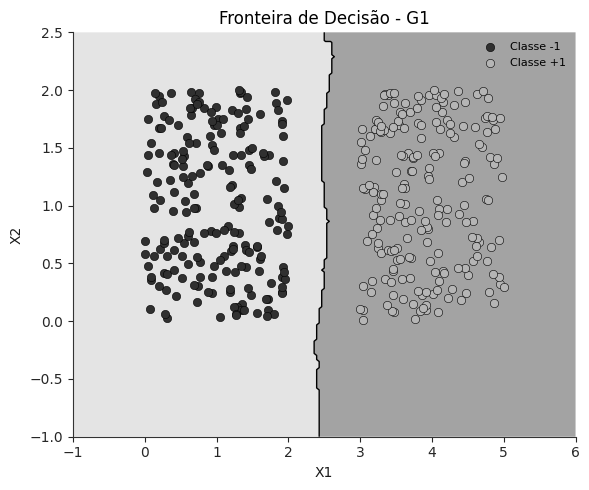

In [ ]:



xx, yy = np.meshgrid(np.linspace(-1,6,200), np.linspace(-1,2.5,200))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([local_hyperplane_classifier(p, hyperplanes) for p in grid]).reshape(xx.shape)
color_neg='#303030'; color_pos='#b5b5b5'; region_neg='#d9d9d9'; region_pos='#7d7d7d'
fig, ax = plt.subplots(figsize=(6,5))
ax.contourf(xx, yy, Z, levels=[-1,0,1], colors=[region_neg, region_pos], alpha=0.70, antialiased=True)
ax.contour(xx, yy, Z, levels=[0], colors='k', linewidths=1.0)
ax.scatter(x[y==-1,0], x[y==-1,1], s=36, c=color_neg, edgecolors='k', linewidths=0.4, label='Classe -1')
ax.scatter(x[y==1,0],  x[y==1,1],  s=36, c=color_pos, edgecolors='k', linewidths=0.4, label='Classe +1')
ax.set_title('Fronteira de Decisão - G1')
ax.set_xlabel('X1'); ax.set_ylabel('X2')
for sp in ['top','right']: ax.spines[sp].set_visible(False)
ax.legend(frameon=False, fontsize=8)
plt.tight_layout(); plt.show()
fig.savefig('decision_boundary_g1.png', dpi=300)

## Exeperimentos comparando a técnica porposta com regressão logística e com o perceptron simples

### Dados 2D
